In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap

import networkx as nx

from minimal.imaging import blit_rooms
from minimal.layout import LayoutGraph, NodeType
from minimal.gen import generate_plan, PlanMasks
from minimal import sample_graphs
from minimal.rooms import RoomAreas, extract_rooms, create_orientation_mask
from minimal.walls import find_walls, intersect_rooms, join_wall_corners, _conv_mask

%matplotlib inline

In [3]:
cmapr = ListedColormap(['white', *plt.get_cmap('tab10').colors])
cmapw = ListedColormap(['white', 'black', *plt.get_cmap('tab10').colors])

In [22]:
%%time
pm = PlanMasks.create_from_state(torch.load("data/plan_masks_01.pth"))
rooms = extract_rooms(pm)

CPU times: user 1.33 s, sys: 0 ns, total: 1.33 s
Wall time: 1.33 s


In [29]:
rect_mask = sum(room.to_mask() * (i + 1) for i, room in enumerate(rooms))

In [55]:
walls_mask, orient_mask, inner_mask = intersect_rooms(rooms)

In [56]:
_, corners = join_wall_corners(walls_mask, inner_mask)

In [68]:
# fmt: off
BOUNDARY_TOP    = 0b0001
BOUNDARY_RIGHT  = 0b0010
BOUNDARY_BOTTOM = 0b0100
BOUNDARY_LEFT   = 0b1000
# fmt: on

# L shaped corner for orientation masking
_kerns3 = torch.tensor([
    [ -1,  2,  0],
    [  2, -1,  0],
    [  0,  0,  0]
], dtype=torch.int8)

all_kerns3 = [
    _kerns3, # R + B
    torch.flip(_kerns3, (0,)), # T + R
    torch.flip(_kerns3, (1,)), # B + L
    torch.flip(_kerns3, (0, 1)), # T + L
]

orientations = [
    BOUNDARY_RIGHT + BOUNDARY_BOTTOM,
    BOUNDARY_TOP + BOUNDARY_RIGHT,
    BOUNDARY_BOTTOM + BOUNDARY_LEFT,
    BOUNDARY_TOP + BOUNDARY_LEFT,
]

corners_orient_mask = torch.zeros_like(orient_mask)

for kern, ort in zip(all_kerns3, orientations):
    cur_corners = _conv_mask(walls_mask, kern, 4) * corners
    corners_orient_mask[torch.where(cur_corners == 1)] = ort

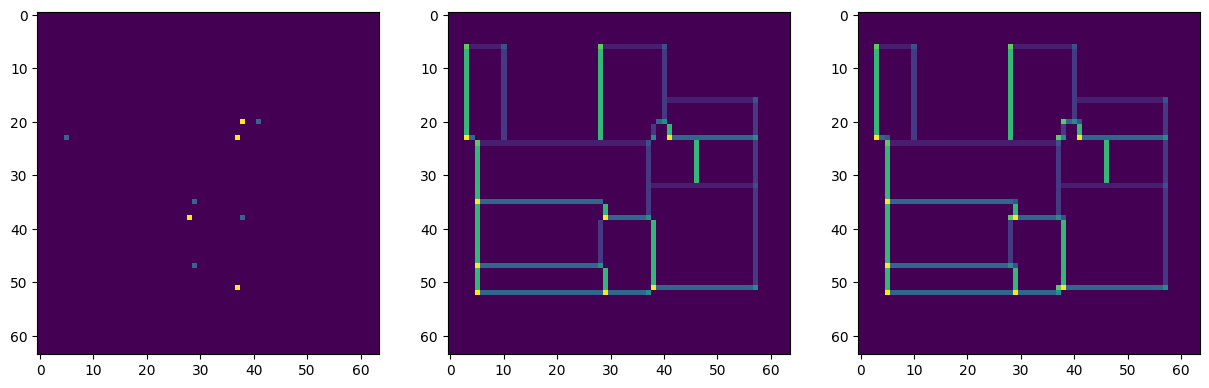

In [69]:
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.imshow(corners_orient_mask)

plt.subplot(132)
plt.imshow(orient_mask)

plt.subplot(133)
plt.imshow(orient_mask + corners_orient_mask)

In [71]:
torch.unique(orient_mask + corners_orient_mask)

tensor([ 0,  1,  2,  3,  4,  6,  8,  9, 12], dtype=torch.uint8)

tensor(True)


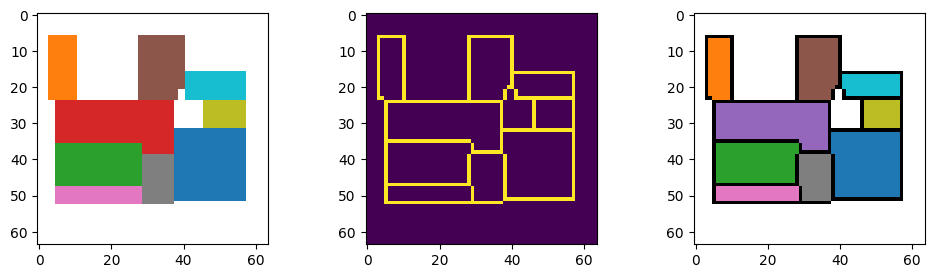

In [72]:
print(torch.all(walls_mask * inner_mask == walls_mask))

plt.figure(figsize=(12,3))

plt.subplot(131)
plt.imshow(rect_mask, cmap=cmapr)

plt.subplot(132)
plt.imshow(walls_mask)

plt.subplot(133)
rooms_with_walls = sum(room.to_mask() * (i + 2) for i, room in enumerate(rooms))
rooms_with_walls[torch.where(walls_mask == 1)] = 1
plt.imshow(rooms_with_walls, cmap=cmapw)